In [37]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os

load_dotenv()

ROOT_DIR = os.getenv("ROOT_DIR")

train_df = pd.read_csv(f"{ROOT_DIR}/introverts-extroverts/train.csv")
train_df.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [38]:
train_df.set_index("id", inplace=True)
train_df.shape

(18524, 8)

In [39]:
train_df.isna().sum() / train_df.shape[0] * 100

Time_spent_Alone              6.424098
Stage_fear                   10.219175
Social_event_attendance       6.370114
Going_outside                 7.914057
Drained_after_socializing     6.202764
Friends_circle_size           5.689916
Post_frequency                6.823580
Personality                   0.000000
dtype: float64

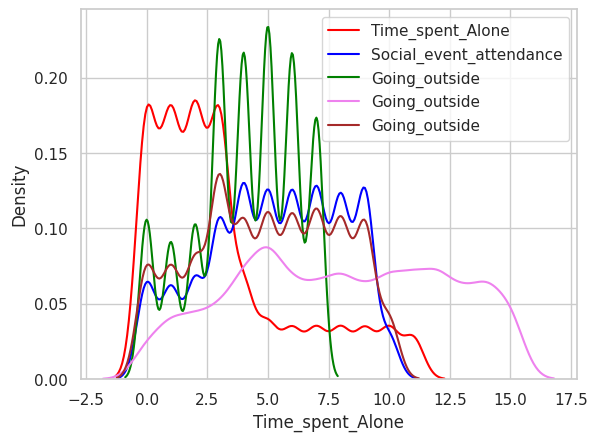

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

sns.kdeplot(train_df["Time_spent_Alone"], color="red", label="Time_spent_Alone")
sns.kdeplot(train_df["Social_event_attendance"], color="blue", label="Social_event_attendance")
sns.kdeplot(train_df["Going_outside"], color="green", label="Going_outside")
sns.kdeplot(train_df["Friends_circle_size"], color="violet", label="Going_outside")
sns.kdeplot(train_df["Post_frequency"], color="brown", label="Going_outside")
plt.legend()
plt.show()

In [41]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

numerical_features = train_df.select_dtypes(include=["int64", "float64"]).columns
categorical_features = train_df.select_dtypes(include=["object"]).columns

categorical_features_onehot = [col for col in categorical_features if col != "Personality"]
personality_feature = ["Personality"]

numerical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

personality_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(categories=[["Introvert", "Extrovert"]], handle_unknown="use_encoded_value", unknown_value=-1))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_pipeline, numerical_features),
        ("cat", categorical_pipeline, categorical_features_onehot),
        ("personality", personality_pipeline, personality_feature)
    ]
)

preprocessor.fit(train_df)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 Index(['Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
       'Friends_circle_size', 'Post_frequency'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Stage_fear', 'Drained_after_socializing']),
                                ('personality',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['Introvert',
                                                                              'Extrovert']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['Personality'])])

In [42]:
transformed_train_values = preprocessor.transform(train_df)
columns_name = preprocessor.get_feature_names_out()

transformed_train_df = pd.DataFrame(transformed_train_values, columns=columns_name)

transformed_train_df.head()

,num__Time_spent_Alone,num__Social_event_attendance,num__Going_outside,num__Friends_circle_size,num__Post_frequency,cat__Stage_fear_No,cat__Stage_fear_Yes,cat__Drained_after_socializing_No,cat__Drained_after_socializing_Yes,personality__Personality
0,-1.079896,0.275846,-0.022392,1.707509,0.006442,1.0,0.0,1.0,0.0,1.0
1,-0.735735,0.651201,-0.527641,0.488428,1.085931,1.0,0.0,1.0,0.0,1.0
2,0.985070,-1.600930,-2.043388,-1.218285,-1.792706,0.0,1.0,1.0,0.0,0.0
3,-0.047413,0.651201,-0.527641,0.732244,0.006442,1.0,0.0,1.0,0.0,1.0
4,-0.735735,-0.474864,-0.022392,1.219876,0.000000,1.0,0.0,1.0,0.0,1.0


In [43]:
from sklearn.model_selection import train_test_split

y = transformed_train_df["personality__Personality"]
X = transformed_train_df.drop(columns=["personality__Personality"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
from sklearn.svm import SVC

svc = SVC(
    kernel="rbf", 
    C=0.1,
    gamma=0.1,
    probability=True,
)

svc.fit(X_train, y_train)

SVC(C=0.1, gamma=0.1, probability=True)

/home/amaury-delille/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/amaury-delille/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


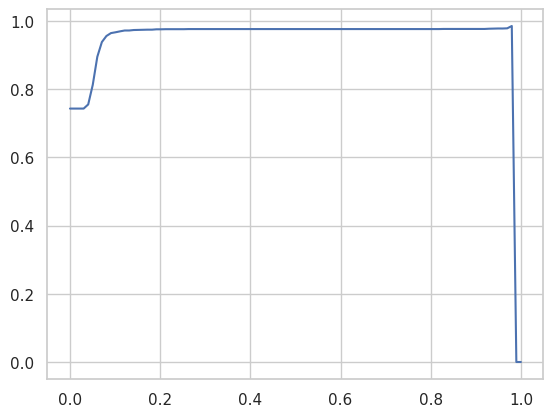

In [45]:
from sklearn.metrics import precision_score, recall_score

thresholds = np.linspace(0, 1, 100)

precision_scores = []
recall_scores = []

for threshold in thresholds:
    y_pred = svc.predict_proba(X_test)[:, 1] > threshold
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))

plt.plot(thresholds, precision_scores, label="Precision")
plt.show()

In [46]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_test, svc.predict(X_test)), recall_score(y_test, svc.predict(X_test))

(0.9761646803900325, 0.9818379949146385)

In [47]:
test_df = pd.read_csv(f"{ROOT_DIR}/introverts-extroverts/test.csv")

test_df.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,18524,3.0,No,7.0,4.0,No,6.0,NaN
1,18525,NaN,Yes,0.0,0.0,Yes,5.0,1.0
2,18526,3.0,No,5.0,6.0,No,15.0,9.0
3,18527,3.0,No,4.0,4.0,No,5.0,6.0
4,18528,9.0,Yes,1.0,2.0,Yes,1.0,1.0


In [ ]:
test_df["Personality"] = None

transformed_test_values = preprocessor.transform(test_df)

all_cols = preprocessor.get_feature_names_out()

mask = all_cols != "personality__Personality"

X_test_t = transformed_test_values[:, mask]
cols_kept = all_cols[mask]

transformed_test_df = pd.DataFrame(X_test_t, columns=cols_kept)

probs = svc.predict_proba(transformed_test_df)[:, 1]
y_labels = ["Introvert", "Extrovert"]
y_pred = np.where(probs > 0.5, y_labels[1], y_labels[0])

submission_df = pd.DataFrame({
    "Id": test_df["id"].astype(int),
    "Personality": y_pred
})
submission_df.to_csv(f"{ROOT_DIR}/introverts-extroverts/submission.csv",
                     index=False)